## Import Dependencies

In [1]:
import sys
import os
import time
import pyvisa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binascii import unhexlify
import serial

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Drivers")

from Driver_PM_PM5020 import *
from Driver_TSL_Goumax import *

## Open Instrument Handles

In [2]:
rm = pyvisa.ResourceManager()
pm = PM_PM5020()
pm.open(rm)
tsl = TSL_TLS200()
tsl.open(rm)

In [3]:
smu = rm.open_resource('ASRL8::INSTR')
smu.baud_rate = 38400

In [4]:
dca = rm.open_resource("TCPIP0::10.10.60.3::inst0::INSTR")

## Wavelength Sweep

In [267]:
wavelength_start = 1530
wavelength_stop = 1610
wavelength_step = 0.1
wavelength = np.linspace(wavelength_start,wavelength_stop,int((wavelength_stop-wavelength_start)/wavelength_step)+1)

tsl.set_output_on()
tsl.set_wavelength(wavelength_start)

pm.set_units(1,"dBm")
pm.set_averaging(1,10)

In [268]:
meas_df = pd.DataFrame()
for i in range(0,len(wavelength)):
    tsl.set_wavelength(wavelength[i])
    time.sleep(0.1)
    power = pm.get_power(1)
    dictionary = {'Wavelength':wavelength[i], 'Power_dBm':power}
    meas_df_temp = pd.DataFrame([dictionary])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)   

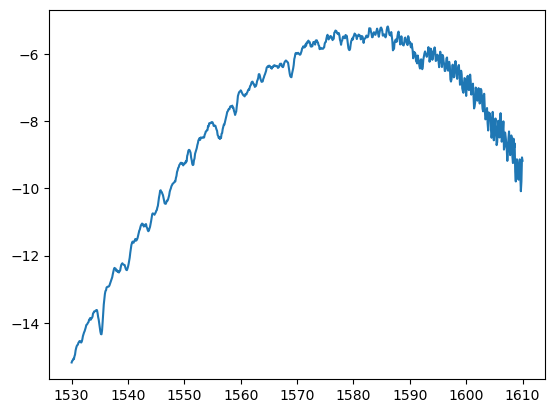

In [269]:
plt.plot(meas_df.Wavelength,meas_df.Power_dBm)

In [270]:
meas_df.to_csv(r"Grating_Loopback_65C.csv")

## Characterize VOA

In [213]:
voltage_start = 0
voltage_stop = 6
voltage_step = 0.05
voltage = np.linspace(voltage_start,voltage_stop,int((voltage_stop-voltage_start)/voltage_step)+1)
meas_df = pd.DataFrame()
for i in range(0,len(voltage)):
    volt=voltage[i]
    smu.write(f"SOUR:VOLT:LEV {volt}")
    time.sleep(0.1)
    power = pm.get_power(1)
    dictionary = {'Voltage':voltage[i], 'Power_dBm':power, 'Power_mW':10**(power/10)}
    meas_df_temp = pd.DataFrame([dictionary])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)   

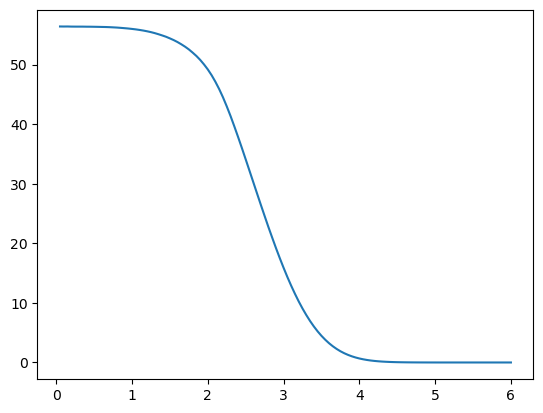

In [214]:
smu.write(f"SOUR:VOLT:LEV 3.5")
plt.plot(meas_df.Voltage,meas_df.Power_mW)

In [215]:
meas_df.to_csv(r"VOA_3.csv")

## Chratacterize VOA over Wavelength

In [7]:
wavelength_start = 1530
wavelength_stop = 1610
wavelength_step = 2
wavelength = np.linspace(wavelength_start,wavelength_stop,int((wavelength_stop-wavelength_start)/wavelength_step)+1)

voltage_start = 0
voltage_stop = 6
voltage_step = 0.05
voltage = np.linspace(voltage_start,voltage_stop,int((voltage_stop-voltage_start)/voltage_step)+1)

tsl.set_output_on()
tsl.set_wavelength(wavelength_start)

pm.set_units(1,"dBm")
pm.set_averaging(1,10)

In [127]:
meas_df = pd.DataFrame()
for i in range(0,len(wavelength)):
    tsl.set_wavelength(wavelength[i])
    time.sleep(0.1)
    for j in range(0,len(voltage)):
        volt=voltage[j]
        smu.write(f"SOUR:VOLT:LEV {volt}")
        time.sleep(0.1)
        power = pm.get_power(1)
        dictionary = {'Wavelength':wavelength[i], 'Voltage':voltage[j], 'Power_dBm':power, 'Power_mW':10**(power/10)}
        meas_df_temp = pd.DataFrame([dictionary])
        data = [meas_df_temp, meas_df]
        meas_df = pd.concat(data,ignore_index=True,sort=False)   

In [128]:
meas_df

,Wavelength,Voltage,Power_dBm,Power_mW
0,1610.0,6.00,-22.3857,0.005773
1,1610.0,5.95,-22.3904,0.005767
2,1610.0,5.90,-22.3935,0.005763
3,1610.0,5.85,-22.4020,0.005752
4,1610.0,5.80,-22.4078,0.005744
...,...,...,...,...
4956,1530.0,0.20,17.4394,55.454909
4957,1530.0,0.15,17.4395,55.456186
4958,1530.0,0.10,inf,inf
4959,1530.0,0.05,inf,inf


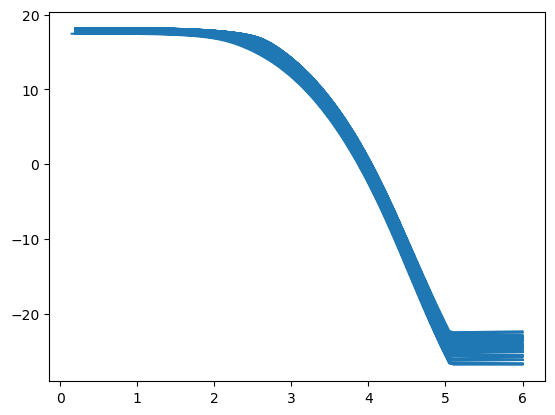

In [129]:
plt.plot(meas_df.Voltage,meas_df.Power_dBm)

In [130]:
meas_df.to_csv(r"VOA_vs_Wavelength_R3.csv")

## Initialization

In [61]:
df = pd.read_csv(r'C:\Users\sramachandra\OneDrive - Inorganic Intelligence, Inc\Sujit\Lab_testing\Zeus_bringup\EAM_characterization\JMP_tables\EAM_Characterization_FIB-B_3a_36_ETX0_Extended\VOA_Parameter_Table.csv')
df

,Wavelength,Intercept,Slope,Quadratic,Cubic,Quartic,Quintic
0,1550,31.422780,-12.848115,2.328160,-0.207446,0.009048,-0.000155
1,1552,30.000683,-12.134389,2.190719,-0.194664,0.008472,-0.000145
2,1554,33.309847,-13.552754,2.429175,-0.214287,0.009263,-0.000157
3,1556,32.830552,-13.245160,2.360440,-0.207200,0.008919,-0.000151
4,1558,32.010997,-12.800162,2.270274,-0.198500,0.008516,-0.000144
5,1560,34.499706,-13.849591,2.444292,-0.212662,0.009082,-0.000153
6,1562,34.009651,-13.535915,2.375002,-0.205610,0.008743,-0.000147
7,1564,35.542689,-14.168262,2.477459,-0.213747,0.009060,-0.000151
8,1566,22.061343,-8.504786,1.543963,-0.138174,0.006052,-0.000104
9,1568,23.124431,-8.965624,1.622386,-0.144707,0.006319,-0.000108


In [97]:
def calculate_voltage(Wavelength, power_dBm):
    a = df[df.Wavelength == Wavelength].Intercept.iloc[0]
    b = df[df.Wavelength == Wavelength].Slope.iloc[0]
    c = df[df.Wavelength == Wavelength].Quadratic.iloc[0]
    d = df[df.Wavelength == Wavelength].Cubic.iloc[0]
    e = df[df.Wavelength == Wavelength].Quartic.iloc[0]
    f = df[df.Wavelength == Wavelength].Quintic.iloc[0]
    voltage = a + b*power_dBm + c*(power_dBm**2) + d*(power_dBm**3) + e*(power_dBm**4) + f*(power_dBm**5)
    return voltage

In [98]:
a1 = -30001.86
b1 = 60.339739
c1 = -0.040335
d1 = 8.9649e-6

def calculate_IL(wavelength_nm):
    IL =  a1 + b1*wavelength_nm + c1*(wavelength_nm**2) + d1*(wavelength_nm**3) + 7.055
    return IL

In [102]:
power_dBm_list = [-1, 0, 1, 2, 3, 4, 5, 6, 6.5, 7]
#power_dBm_list = [6, 6.5, 7]
wavelength_start = 1550
wavelength_stop = 1594
wavelength_step = 2 #0.1
wavelength = np.linspace(wavelength_start,wavelength_stop,int((wavelength_stop-wavelength_start)/wavelength_step)+1)

Temperature_C = 35
EAM_Bias_V = 0.5
meas_df = pd.DataFrame(columns=['Voltage (V)', 'FAU Input Power (dBm)', 'Insertion Loss (dB)', 'EAM Input Power (dBm)', 'Wavelength (nm)', 
                                'EAM Anode Bias (V)', 'Temperature (C)', 'Avg Power (uW)', 'OMA (uW)', 'ER (dB)', 
                                'Avg Power Min (uW)', 'Avg Power Max (uW)', 'Avg Power StdDev (uW)', 'OMA Min (uW)', 'OMA Max (uW)', 'OMA StdDev (uW)',
                                'Base Power Avg (uW)', 'Base Power Min (uW)', 'Base Power Max (uW)', 'Base Power Stddev (uW)',
                                'Top Power Avg (uW)', 'Top Power Min (uW)', 'Top Power Max (uW)', 'Top Power Stddev (uW)', 
                                'Base Status', 'Top Status', 'OMA_Status', 'Avg_Status'])

In [103]:
smu.write(":SENS:CURR:PROT 4E-3")
smu.write(":SOUR:VOLT:PROT 20")
smu.write(":SOUR:FUNC VOLT")
smu.write(":SOUR:VOLT:MODE FIX")
smu.write(":SENS:FUNC \"VOLT\"")
smu.write(":SENS:CURR:RANG 0.0001")
smu.write(":OUTP ON")
smu.write("FORM:ELEM CURR")
smu.write(f"SOUR:VOLT:LEV 3.39")

20

## Measurement Routine

In [104]:
count = 1
baseline = -143.12e-6 
for i in range (0,len(power_dBm_list)):
    for j in range(0,len(wavelength)):
        tsl.set_wavelength(wavelength[j])
        IL = calculate_IL(wavelength[j])
        set_power = power_dBm_list[i] + IL
        if set_power < 17.5:
            VOA_bias = calculate_voltage(wavelength[j], set_power)
            smu.write(f"SOUR:VOLT:LEV {VOA_bias}")
            time.sleep(0.1)
            x=smu.query("READ?")  
            dca.write(":ACQ:CDIS")  #clear
            
            dca.write(f":FUNC:YSC 5e-4")
            dca.write(f":FUNC:YOFF 0")
            time.sleep(1.5)
            table=dca.query(":MEAS:RES?").split(",")  # get result table
            power_avg_mean_level = float(table[22].split("=")[1])
            power_base_mean_level = float(table[4].split("=")[1]) 
            power_top_mean_level = float(table[13].split("=")[1])
            scale = (power_top_mean_level - power_base_mean_level) / 4
            offset = power_avg_mean_level - 2*scale
            dca.write(f":FUNC:YSC {scale}")
            dca.write(f":FUNC:YOFF {offset}")

            dca.write(":TIM:SCAL 1.0E-10")
            #dca.write(":ACQ:CDIS")  #clear
            time.sleep(1)
            dca.write(":MEAS:OSC:APOW:SOUR CHANF1")
            table=dca.query(":MEAS:RES?").split(",")  # get result table
            table=[x.rstrip() for x in table]
            #print(table)
                
            power_base_mean = float(table[4].split("=")[1]) - baseline
            power_base_stddev = float(table[5].split("=")[1]) - baseline
            power_base_min = float(table[6].split("=")[1]) - baseline
            power_base_max = float(table[7].split("=")[1]) - baseline

            power_top_mean = float(table[13].split("=")[1]) - baseline
            power_top_stddev = float(table[14].split("=")[1]) - baseline
            power_top_min = float(table[15].split("=")[1]) - baseline
            power_top_max = float(table[16].split("=")[1]) - baseline

            power_avg_mean = float(table[22].split("=")[1]) - baseline
            power_avg_stddev = float(table[23].split("=")[1]) - baseline
            power_avg_min = float(table[24].split("=")[1]) - baseline
            power_avg_max = float(table[25].split("=")[1]) - baseline

            oma_mean = float(table[31].split("=")[1])
            oma_stddev = float(table[32].split("=")[1])
            oma_min = float(table[33].split("=")[1])
            oma_max = float(table[34].split("=")[1])
            
            base_status =  table[3].split("=")[1]
            top_status = table[12].split("=")[1]
            oma_status = table[30].split("=")[1]
            avg_status = table[21].split("=")[1]

            meas_df.loc[count] = [VOA_bias, set_power, IL, power_dBm_list[i], wavelength[j] ,EAM_Bias_V, Temperature_C, power_avg_mean*1e6, 
            oma_mean*1e6, 10*np.log10((power_avg_mean+0.5*oma_mean)/(power_avg_mean-0.5*oma_mean)), power_avg_min*1e6, 
            power_avg_max*1e6, power_avg_stddev*1e6, oma_min*1e6, oma_max*1e6, oma_stddev*1e6,
            power_base_mean*1e6, power_base_min*1e6, power_base_max*1e6, power_base_stddev*1e6, 
            power_top_mean*1e6, power_top_min*1e6, power_top_max*1e6, power_top_stddev*1e6,
            base_status, top_status, oma_status, avg_status]
            
        count = count + 1

In [105]:
meas_df

,Voltage (V),FAU Input Power (dBm),Insertion Loss (dB),EAM Input Power (dBm),Wavelength (nm),EAM Anode Bias (V),Temperature (C),Avg Power (uW),OMA (uW),ER (dB),...,Base Power Max (uW),Base Power Stddev (uW),Top Power Avg (uW),Top Power Min (uW),Top Power Max (uW),Top Power Stddev (uW),Base Status,Top Status,OMA_Status,Avg_Status
1,3.276601,10.119937,11.119937,-1.0,1550.0,0.5,35,30.0800,23.348,3.557387,...,18.27,153.92,51.10,41.97,69.77,153.58,Correct,Correct,Invalid,Invalid
2,3.292713,9.956928,10.956928,-1.0,1552.0,0.5,35,35.2792,28.840,3.770517,...,21.27,148.45,59.03,48.47,71.92,154.21,Correct,Correct,Correct,Correct
3,3.312727,9.805163,10.805163,-1.0,1554.0,0.5,35,45.3634,37.799,3.853065,...,26.52,154.34,82.71,61.67,89.42,152.25,Correct,Correct,Correct,Correct
4,3.327386,9.665073,10.665073,-1.0,1556.0,0.5,35,50.1600,39.568,3.622199,...,30.17,151.67,83.92,67.27,92.82,152.80,Correct,Correct,Correct,Correct
5,3.341104,9.537088,10.537088,-1.0,1558.0,0.5,35,58.3212,45.716,3.596668,...,36.52,153.38,96.49,79.22,106.57,154.51,Correct,Correct,Correct,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2.408505,17.102111,10.102111,7.0,1582.0,0.5,35,315.0334,106.890,1.487936,...,261.12,143.58,364.84,363.82,365.57,143.58,Correct,Correct,Correct,Correct
225,2.389622,17.170653,10.170653,7.0,1584.0,0.5,35,311.9150,100.229,1.407735,...,261.02,143.42,358.99,358.42,359.52,143.43,Correct,Correct,Correct,Correct
226,2.365808,17.257324,10.257324,7.0,1586.0,0.5,35,332.2506,96.072,1.264646,...,282.92,143.62,378.06,377.17,378.92,143.65,Correct,Correct,Correct,Correct
227,2.332347,17.362556,10.362556,7.0,1588.0,0.5,35,788.3344,209.153,1.159058,...,674.82,143.87,881.85,880.07,882.52,143.78,Correct,Correct,Correct,Correct


In [106]:
meas_df.to_csv(r"35C_0.5.csv")

In [107]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Manual Debug

In [33]:
tsl.set_wavelength(1577)
IL = calculate_IL(1577)
set_power = 4 + IL
VOA_bias = calculate_voltage(1576, set_power)
print(VOA_bias)

3744.9796604822077


In [28]:
IL = calculate_IL(1530)
print(IL)

10.647827299989643


In [30]:
print(VOA_bias)

400.20730408417785


In [109]:
pm.close()
tsl.close()
smu.close()
dca.close()

In [108]:
tsl.set_output_off()
smu.write(":OUTP OFF")

11

In [96]:
wavelength = 1586
tsl.set_wavelength(wavelength)
IL = calculate_IL(wavelength)
set_power = 6 + IL
VOA_bias = calculate_voltage(wavelength, set_power)
smu.write(f"SOUR:VOLT:LEV {VOA_bias}")

dca.write(":ACQ:CDIS")  #clear       
dca.write(f":FUNC:YSC 5e-4")
dca.write(f":FUNC:YOFF 0")
time.sleep(1.5)
table=dca.query(":MEAS:RES?").split(",")  # get result table
power_avg_mean_level = float(table[22].split("=")[1])
power_base_mean_level = float(table[4].split("=")[1]) 
power_top_mean_level = float(table[13].split("=")[1])
scale = (power_top_mean_level - power_base_mean_level) / 4
offset = power_avg_mean_level - 2*scale
dca.write(f":FUNC:YSC {scale}")
dca.write(f":FUNC:YOFF {offset}")
dca.write(":TIM:SCAL 1.0E-10")

19

In [6]:
smu.write(":OUTP ON")
smu.write(f"SOUR:VOLT:LEV 4.04")

20

In [191]:
pm.get_power(1)

6.25564

In [284]:
dca.write(f":FUNC:YSC 5e-4")
dca.write(f":FUNC:YOFF 0")
table=dca.query(":MEAS:RES?").split(",")  # get result table
power_avg_mean_level = float(table[22].split("=")[1])
power_base_mean_level = float(table[4].split("=")[1]) 
power_top_mean_level = float(table[13].split("=")[1])
scale = (power_top_mean_level - power_base_mean_level) / 4
offset = power_avg_mean_level - 2*scale
dca.write(f":FUNC:YSC {scale}")
dca.write(f":FUNC:YOFF {offset}")

35

In [5]:
tsl.set_output_on()

In [384]:
smu.write(":OUTP OFF")

11

In [55]:
smu.close()

In [75]:
print(VOA_bias)

3.455112701027473


In [8]:
tsl = TSL_TLS200()
tsl.open(rm)

In [35]:
dca.write(":DISK:SIM:FNAM "%DESKTOP%\EAM\asd.jpg"")
dca.write(":DISK:SIM:SAVE")
dca.write("*OPC?")

SyntaxError: unexpected character after line continuation character (1334506892.py, line 1)